In [1]:
! pip install monai

     |████████████████████████████████| 584 kB 5.2 MB/s 


In [2]:
import monai
import os
os.chdir('/content/drive/MyDrive/ColabNotebooks/IndividualProject_Toolseg')
import math
import numpy as np
import time
import random
import cv2
import pickle
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
from PIL import Image
from torch import functional as F
# from resnet18camds import resnet18_cam_ds
from torch.autograd import Variable
from functools import partial
from typing import Any, Callable, List, Type, Union
import torch.nn as nn
from monai.networks.layers.factories import Conv, Norm, Pool


**Model Definition**

In [ ]:
__all__ = ["ResNet", "resnet18"]


def get_inplanes():
    return [64, 128, 256, 512]


def get_avgpool():
    return [(0), (1), (1, 1), (1, 1, 1)]


def get_conv1(conv1_t_size: int, conv1_t_stride: int):
    return (
        [(0), (conv1_t_size), (conv1_t_size, 7), (conv1_t_size, 7, 7)],
        [(0), (conv1_t_stride), (conv1_t_stride, 2), (conv1_t_stride, 2, 2)],
        [(0), (conv1_t_size // 2), (conv1_t_size // 2, 3), (conv1_t_size // 2, 3, 3)],
    )


class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 1, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 1, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class ResNetBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        in_planes: int,
        planes: int,
        spatial_dims: int = 3,
        stride: int = 1,
        downsample: Union[nn.Module, partial, None] = None,
    ) -> None:
        """
        Args:
            in_planes: number of input channels.
            planes: number of output channels.
            spatial_dims: number of spatial dimensions of the input image.
            stride: stride to use for first conv layer.
            downsample: which downsample layer to use.
        """
        super(ResNetBlock, self).__init__()

        conv_type: Callable = Conv[Conv.CONV, spatial_dims]
        norm_type: Callable = Norm[Norm.BATCH, spatial_dims]

        self.conv1 = conv_type(in_planes, planes, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = norm_type(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv_type(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = norm_type(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x

        out: torch.Tensor = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNetBottleneck(nn.Module):
    expansion = 4

    def __init__(
        self,
        in_planes: int,
        planes: int,
        spatial_dims: int = 3,
        stride: int = 1,
        downsample: Union[nn.Module, partial, None] = None,
    ) -> None:
        """
        Args:
            in_planes: number of input channels.
            planes: number of output channels (taking expansion into account).
            spatial_dims: number of spatial dimensions of the input image.
            stride: stride to use for second conv layer.
            downsample: which downsample layer to use.
        """

        super(ResNetBottleneck, self).__init__()

        conv_type: Callable = Conv[Conv.CONV, spatial_dims]
        norm_type: Callable = Norm[Norm.BATCH, spatial_dims]

        self.conv1 = conv_type(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = norm_type(planes)
        self.conv2 = conv_type(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = norm_type(planes)
        self.conv3 = conv_type(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = norm_type(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x

        out: torch.Tensor = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    """
    ResNet based on: `Deep Residual Learning for Image Recognition <https://arxiv.org/pdf/1512.03385.pdf>`_
    and `Can Spatiotemporal 3D CNNs Retrace the History of 2D CNNs and ImageNet? <https://arxiv.org/pdf/1711.09577.pdf>`_.
    Adapted from `<https://github.com/kenshohara/3D-ResNets-PyTorch/tree/master/models>`_.
    Args:
        block: which ResNet block to use, either Basic or Bottleneck.
        layers: how many layers to use.
        block_inplanes: determine the size of planes at each step. Also tunable with widen_factor.
        spatial_dims: number of spatial dimensions of the input image.
        n_input_channels: number of input channels for first convolutional layer.
        conv1_t_size: size of first convolution layer, determines kernel and padding.
        conv1_t_stride: stride of first convolution layer.
        no_max_pool: bool argument to determine if to use maxpool layer.
        shortcut_type: which downsample block to use.
        widen_factor: widen output for each layer.
        n_classes: number of output (classifications)
    """

    def __init__(
        self,
        block: Type[Union[ResNetBlock, ResNetBottleneck]],
        layers: List[int],
        block_inplanes: List[int],
        spatial_dims: int = 3,
        n_input_channels: int = 3,
        conv1_t_size: int = 7,
        conv1_t_stride: int = 1,
        no_max_pool: bool = False,
        shortcut_type: str = "B",
        widen_factor: float = 1.0,
        n_classes: int = 400,
        feed_forward: bool = True,
    ) -> None:

        super(ResNet, self).__init__()

        conv_type: Type[Union[nn.Conv1d, nn.Conv2d, nn.Conv3d]] = Conv[Conv.CONV, spatial_dims]
        norm_type: Type[Union[nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d]] = Norm[Norm.BATCH, spatial_dims]
        pool_type: Type[Union[nn.MaxPool1d, nn.MaxPool2d, nn.MaxPool3d]] = Pool[Pool.MAX, spatial_dims]
        avgp_type: Type[Union[nn.AdaptiveAvgPool1d, nn.AdaptiveAvgPool2d, nn.AdaptiveAvgPool3d]] = Pool[
            Pool.ADAPTIVEAVG, spatial_dims
        ]

        block_avgpool = get_avgpool()
        conv1_kernel, conv1_stride, con1_padding = get_conv1(conv1_t_size, conv1_t_stride)
        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = conv_type(
            n_input_channels,
            self.in_planes,
            kernel_size=conv1_kernel[spatial_dims],
            # stride=conv1_stride[spatial_dims],
            stride=2,
            padding=con1_padding[spatial_dims],
            bias=False,
        )
        self.bn1 = norm_type(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = pool_type(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0], spatial_dims, shortcut_type)
        self.layer2 = self._make_layer(block, block_inplanes[1], layers[1], spatial_dims, shortcut_type, stride=2)
        self.layer3 = self._make_layer(block, block_inplanes[2], layers[2], spatial_dims, shortcut_type, stride=2)
        self.layer4 = self._make_layer(block, block_inplanes[3], layers[3], spatial_dims, shortcut_type, stride=2)
        self.avgpool = avgp_type(block_avgpool[spatial_dims])
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        # self.bn_gap = nn.BatchNorm2d()
        # self.conv_gap1 = conv_type(64, 2, kernel_size=1, padding=0, stride=1, bias=False)
        self.conv_gap1 = nn.Conv2d(kernel_size=(1,1), stride=1, padding=0, out_channels=2 , in_channels=64, bias=False)
        self.conv_gap2 = nn.Conv2d(kernel_size=(1,1), stride=1, padding=0, out_channels=2 , in_channels=64, bias=False)
        self.conv_gap3 = nn.Conv2d(kernel_size=(1,1), stride=1, padding=0, out_channels=2 , in_channels=128, bias=False)
        self.conv_gap4 = nn.Conv2d(kernel_size=(1,1), stride=1, padding=0, out_channels=2 , in_channels=256, bias=False)
        self.conv_gap5 = nn.Conv2d(kernel_size=(1,1), stride=1, padding=0, out_channels=2 , in_channels=512, bias=False)
        # self.cbam = CBAM(channel=2)
        self.ca = ChannelAttention(2)
        self.sa = SpatialAttention()

        if feed_forward:
            self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, conv_type):
                nn.init.kaiming_normal_(torch.as_tensor(m.weight), mode="fan_out", nonlinearity="relu")
            elif isinstance(m, norm_type):
                nn.init.constant_(torch.as_tensor(m.weight), 1)
                nn.init.constant_(torch.as_tensor(m.bias), 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(torch.as_tensor(m.bias), 0)

    def _downsample_basic_block(self, x: torch.Tensor, planes: int, stride: int, spatial_dims: int = 3) -> torch.Tensor:
        assert spatial_dims == 3
        out: torch.Tensor = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2), out.size(3), out.size(4))
        if isinstance(out.data, torch.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(
        self,
        block: Type[Union[ResNetBlock, ResNetBottleneck]],
        planes: int,
        blocks: int,
        spatial_dims: int,
        shortcut_type: str,
        stride: int = 1,
    ) -> nn.Sequential:

        conv_type: Callable = Conv[Conv.CONV, spatial_dims]
        norm_type: Callable = Norm[Norm.BATCH, spatial_dims]

        downsample: Union[nn.Module, partial, None] = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == "A":
                downsample = partial(
                    self._downsample_basic_block, planes=planes * block.expansion, kernel_size=1, stride=stride
                )
            else:
                downsample = nn.Sequential(
                    conv_type(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride),
                    norm_type(planes * block.expansion),
                )

        layers = []
        layers.append(
            block(
                in_planes=self.in_planes, planes=planes, spatial_dims=spatial_dims, stride=stride, downsample=downsample
            )
        )
        self.in_planes = planes * block.expansion
        for _i in range(1, blocks):
            layers.append(block(self.in_planes, planes, spatial_dims=spatial_dims))

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        #1/2
        x = self.bn1(x)
        x = self.relu(x)
        conv_gap1 = self.conv_gap1(x)
        ca1 = self.ca(conv_gap1)*conv_gap1
        sa1 = self.sa(ca1)*ca1
        gap1 = self.gap(sa1)
        x = self.layer1(x)
        conv_gap2 = self.conv_gap2(x)
        ca2 = self.ca(conv_gap2)*conv_gap2
        sa2 = self.sa(ca2)*ca2
        gap2 = self.gap(sa2)
        x = self.layer2(x)
        conv_gap3 = self.conv_gap3(x)
        gap3 = self.gap(conv_gap3)
        x = self.layer3(x)
        conv_gap4 = self.conv_gap4(x)
        gap4 = self.gap(conv_gap4)
        x = self.layer4(x)
        conv_gap5 = self.conv_gap5(x)
        gap5 = self.gap(conv_gap5)
        y = gap1 * 0.35 + gap2 * 0.35 + gap3 * 0.1 + gap4 * 0.1 + gap5 * 0.1

        return y.squeeze(dim = -1).squeeze(dim = -1)


def _resnet(
    arch: str,
    block: Type[Union[ResNetBlock, ResNetBottleneck]],
    layers: List[int],
    block_inplanes: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any,
) -> ResNet:
    model = ResNet(block, layers, block_inplanes, **kwargs)
    if pretrained:
        # Author of paper zipped the state_dict on googledrive,
        # so would need to download, unzip and read (2.8gb file for a ~150mb state dict).
        # Would like to load dict from url but need somewhere to save the state dicts.
        raise NotImplementedError("Currently not implemented, see comments in source code")
    return model


def resnet18_cbam_cam_ds(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    """ResNet-18 with optional pretrained support when `spatial_dims` is 3.
    Pretraining from `Med3D: Transfer Learning for 3D Medical Image Analysis <https://arxiv.org/pdf/1904.00625.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on 23 medical datasets
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet("resnet18", ResNetBlock, [2, 2, 2, 2], get_inplanes(), pretrained, progress, **kwargs)


**DataLoader Definition**


In [ ]:
def data_load(data_dir, batch_size, num, train_txt):
    print('Begin data load:')
    train_txt = train_txt
    with open(train_txt) as f:
        train_list = f.readlines()
    train_list = [x.split('.')[0] for x in train_list]
    print('pics nums {}'.format(len(train_list)))
    random.shuffle(train_list)
    train_img_name = train_list[:num]
    train_label = np.zeros((len(train_img_name)))
    for i in range(len(train_img_name)):
        train_label[i] = int(train_img_name[i][-1])

    data_all = []
    data_all_img = []
    data_all_label = []
    for i in range(math.floor(num / batch_size)):
        batch_data_img = []
        batch_data_label = []
        for j in range(batch_size):
            # print(str(i * batch_size + j + 1) + ' / ' + str(num))
            train_img_batch = Image.open(data_dir + train_img_name[i * batch_size + j][:] + '.png')
            train_img_single = train_img_batch.resize((512, 256))
            train_img_single = np.array(train_img_single)
            train_img_single = np.transpose(train_img_single, (2, 0, 1))
            batch_data_img.append(train_img_single)
            batch_data_label.append(np.array(train_img_name[i * batch_size + j][-1]).astype('int8'))

        data_all_img.append(batch_data_img)
        data_all_label.append(batch_data_label)
        
    data_all_img = torch.from_numpy(np.array(data_all_img))
    data_all_img = data_all_img.float()
    data_all_label = torch.from_numpy(np.array(data_all_label))
    data_all_label = data_all_label.long()
    return data_all_img, data_all_label

**Loss Function**

In [ ]:

class SideLoss(torch.nn.Module):
    def __init__(self):
        super(SideLoss, self).__init__()
        # self.deta = deta

    def forward(self, out, label):
        loss = 0
        for i in range(len(label)):
            loss = loss - (label[i] * torch.log(torch.softmax(out[i],dim = 0)[1])) - (1- label[i])* (torch.log(torch.softmax(out[i],dim = 0)[0]))
        loss = loss / len(label)
        return loss


**Train Stage**

In [ ]:

train_data_path = './datasets/all/'
batch_size = 16
num = 180
data_all_img, data_all_label = data_load(train_data_path, batch_size, num, 'train.txt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = resnet18_cbam_cam_ds(spatial_dims=2, n_input_channels = 3, n_classes = 2).to(device)
loss_function = SideLoss()

# loss_function = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
StepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
epoch_loss_values = []
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
all_acc = []

for epoch in range(0):
    StepLR.step()
    lr = StepLR.get_lr()
    print('epoch: ' + str(epoch + 1))
    print('lr :' + str(lr[0]))
    model.train()
    epoch_loss = 0
    step = 0
    right = 0
    for i in range(len(data_all_img)):
        step += 1
        inputs, labels = data_all_img[i].to(device), data_all_label[i].to(device)
        optimizer.zero_grad()
        y = model(inputs)
        loss_y = loss_function(y, labels)
        loss = loss_y
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = num // batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.7f}")
        for j in range(batch_size):
            if np.argmax(y.cpu().detach().numpy(),axis=1)[j] == labels.cpu().detach().numpy()[j]:
                right = right + 1

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    all_acc.append((right / len(data_all_img) / batch_size))
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.7f}")
    print(f"acc : {(right / len(data_all_img) / batch_size):.7f}")
    torch.save(model, 'models/model_' + str(epoch) + '.pkl')
    torch.save(model.state_dict(), 'models/model_state_dic_' + str(epoch) + '.pkl')
    # print(np.argmax(outputs.cpu().detach().numpy(),axis=1), labels.cpu().detach().numpy())


Streaming output truncated to the last 5000 lines.
121/390, train_loss: 0.0013499
122/390, train_loss: 0.0014218
123/390, train_loss: 0.0016259
124/390, train_loss: 0.0017120
125/390, train_loss: 0.0007991
126/390, train_loss: 0.0017365
127/390, train_loss: 0.0009034
128/390, train_loss: 0.0011355
129/390, train_loss: 0.0010655
130/390, train_loss: 0.0012685
131/390, train_loss: 0.0010410
132/390, train_loss: 0.0030301
133/390, train_loss: 0.0007953
134/390, train_loss: 0.0010765
135/390, train_loss: 0.0019857
136/390, train_loss: 0.0020611
137/390, train_loss: 0.0023180
138/390, train_loss: 0.0015622
139/390, train_loss: 0.0012285
140/390, train_loss: 0.0017354
141/390, train_loss: 0.0016749
142/390, train_loss: 0.0010860
143/390, train_loss: 0.0015583
144/390, train_loss: 0.0015037
145/390, train_loss: 0.0010158
146/390, train_loss: 0.0019275
147/390, train_loss: 0.0009519
148/390, train_loss: 0.0012163
149/390, train_loss: 0.0027098
150/390, train_loss: 0.0022901
151/390, train_loss

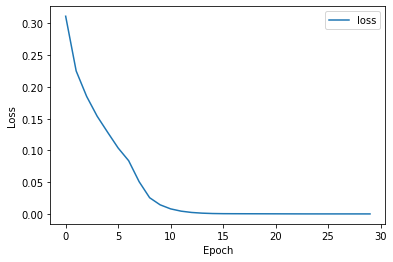

In [ ]:
# plt.plot(range(len(all_acc)),all_acc,label='acc')
plt.plot(range(len(epoch_loss_values)),epoch_loss_values,label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
os.listdir('./')

['resnet18camds.py',
 'model_state_dic_29.pkl',
 '__pycache__',
 'train_50000.txt',
 'train_2000.txt',
 'train_100000.txt',
 'picture-selected',
 'colab_1.ipynb',
 'datasets',
 'train.txt']

**Test Stage**

In [ ]:
def draw_cam_fun(model, img_path, save_path, transform=None, visheatmap=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    features = None
    start = time.time()
    img = Image.open(img_path).convert('RGB')
    img = img.resize((512, 256))
    img = np.array(img)
    start = time.time()
    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img).to(device)
    img = img.float()
    img = img.unsqueeze(0)
    model.eval()
    x = model.conv1(img)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.layer1(x)
  
    conv_gap2 = model.conv_gap2(x)
    ca2 = model.ca(conv_gap2) * conv_gap2
    sa2 = model.sa(ca2) * ca2
    features = sa2  # 1x2048x7x7


    def extract(g):
        global feature_grad
        feature_grad = g

    features.register_hook(extract)
    features= features[0]

    heatmap = features.cpu().detach().numpy()
    heatmap = heatmap[0]
    heatmap /= np.max(heatmap)

    heatmap_gray = np.expand_dims(heatmap, axis= -1)
    heatmap_gray = Image.fromarray((heatmap * 255).astype('uint8')).convert('L')
    print('seg time {}ms'.format(start))

    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap
    cv2.imwrite(save_path, superimposed_img)
    return superimposed_img



In [ ]:
test_dir = './picture-selected/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = resnet18_cbam_cam_ds(spatial_dims=2, n_input_channels=3, n_classes=2).to(device)
model.load_state_dict(torch.load('cbam_model_state_dic_29.pkl'))


<All keys matched successfully>

seg time:9.26806695068631
seg time:8.956766929929813
seg time:8.843503738522822
seg time:9.159107443656737


<Figure size 432x288 with 0 Axes>

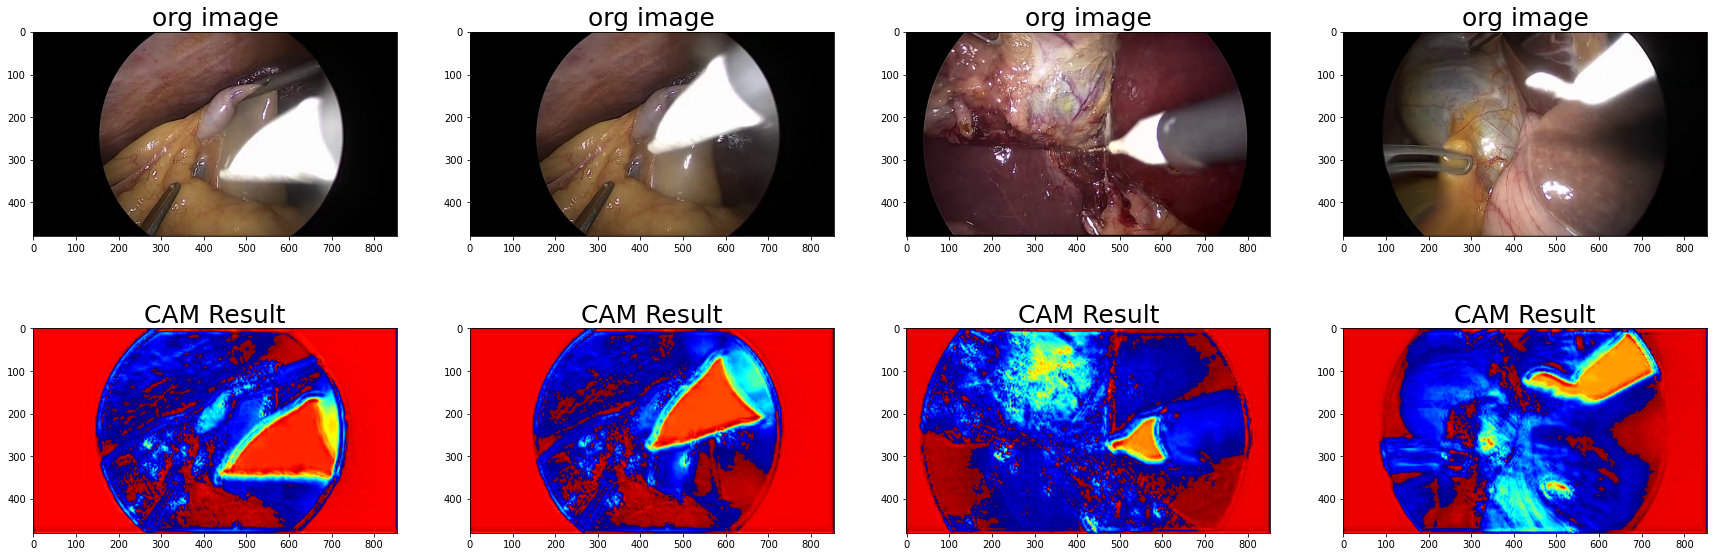

In [10]:
plt.figure()
lw = 2
plt.figure(figsize=(30,10))
img_paths = [test_dir + 'frame_989_endo.png', test_dir + 'frame_990_endo.png', test_dir + 'frame_28939_endo.png', test_dir + 'frame_527_endo.png']
for idx, img_pth in enumerate(img_paths):
  heatmap = draw_cam_fun(model, img_pth, output_pth)
  img = Image.open(img_pth)
  plt.subplot(2, 4, idx + 1)
  plt.imshow(img)
  plt.title('org image',fontsize=25)
  plt.subplot(2, 4, idx + 1 + 4)
  img = Image.open(output_pth)
  plt.imshow(img)
  plt.title('CAM Result',fontsize=25)
plt.show()

Define and plot the ROC curves

In [ ]:
def draw_roc_curve(label_pth, pred_pth):
  labels = []
  preds = []
  img_height, img_width = 0, 0
  for x in sorted(os.listdir(pred_pth)):
    # x = 'frame_28934_endo.png'
    pred = Image.open(os.path.join(pred_pth, x))
    img_width, img_height = pred.size
    pred = np.array(pred)
    pred[pred > 0] = 1
    pred = pred.flatten()
    preds.extend(pred)
    # preds = pred

  for x in sorted(os.listdir(label_pth)):
    # x = 'frame_28934_endo.png'
    label = Image.open(os.path.join(label_pth, x)).convert('L').resize((img_width, img_height))
    label = np.array(label)
    label[label > 0] = 1
    label = label.flatten()
    labels.extend(label)
    # labels = label

  fpr,tpr,threshold = roc_curve(labels, preds)
  roc_auc = auc(fpr,tpr)
  return fpr, tpr, roc_auc


<Figure size 432x288 with 0 Axes>

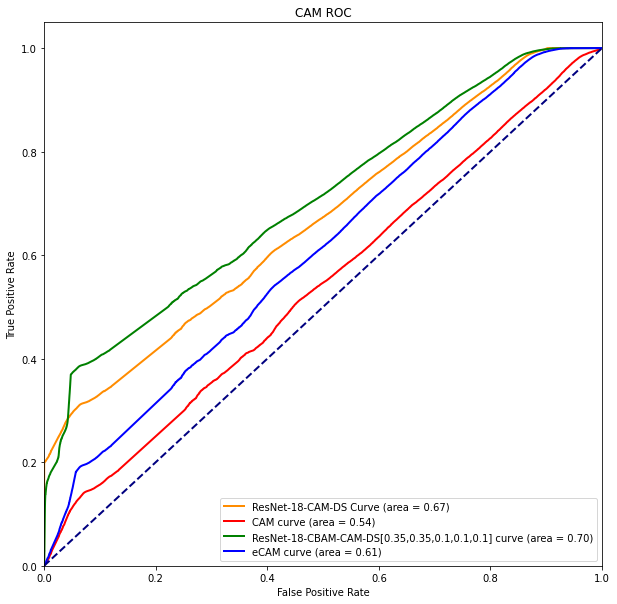

In [ ]:
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
fpr, tpr, roc_auc = draw_roc_curve('./label', './cam_ds')
plt.plot(fpr, tpr, color='darkorange',

         lw=lw, label='ResNet-18-CAM-DS Curve (area = %0.2f)' % roc_auc) #The x-axis showing 1 – specificity (= false positive fraction = FP/(FP+TN))；The y-axis showing sensitivity (= true positive fraction = TP/(TP+FN))


fpr, tpr, roc_auc = draw_roc_curve('./label', './cam')
plt.plot(fpr, tpr, color='red',
         lw=lw, label='CAM curve (area = %0.2f)' % roc_auc)

fpr, tpr, roc_auc = draw_roc_curve('./label', './cbam')
plt.plot(fpr, tpr, color='green',
         lw=lw, label='ResNet-18-CBAM-CAM-DS[0.35,0.35,0.1,0.1,0.1] curve (area = %0.2f)' % roc_auc)

fpr, tpr, roc_auc = draw_roc_curve('./label', './ecam')

plt.plot(fpr, tpr, color='blue',
         lw=lw, label='eCAM curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CAM ROC')
plt.legend(loc="lower right")
plt.savefig('t.png')
plt.show()

Show tool segmentation prediction results of different models


In [ ]:
def draw_seg(model, img_path, save_path, transform=None, visheatmap=False):
  threshold = 0.6
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  start = time.time()
  img = Image.open(img_path).convert('RGB')
  img = img.resize((512, 256))
  img = np.array(img)

  img = np.transpose(img, (2, 0, 1))
  img = torch.from_numpy(img).to(device)
  img = img.float()

  img = img.unsqueeze(0)
  model.eval()
  x = model.conv1(img)
  x = model.bn1(x)
  x = model.relu(x)

  x = model.layer1(x)

  conv_gap2 = model.conv_gap2(x)
  features = conv_gap2  # 1x2048x7x7


  def extract(g):
      global feature_grad
      feature_grad = g

  features= features[0]

  heatmap = features.cpu().detach().numpy()
  heatmap = heatmap[1]

  heatmap /= np.max(heatmap)
  heatmap[heatmap < threshold] = 0
  heatmap[heatmap >= threshold] = 1
  heatmap_gray = Image.fromarray((heatmap * 255).astype('uint8')).convert('L')
  heatmap_gray.save(save_path)



<Figure size 432x288 with 0 Axes>

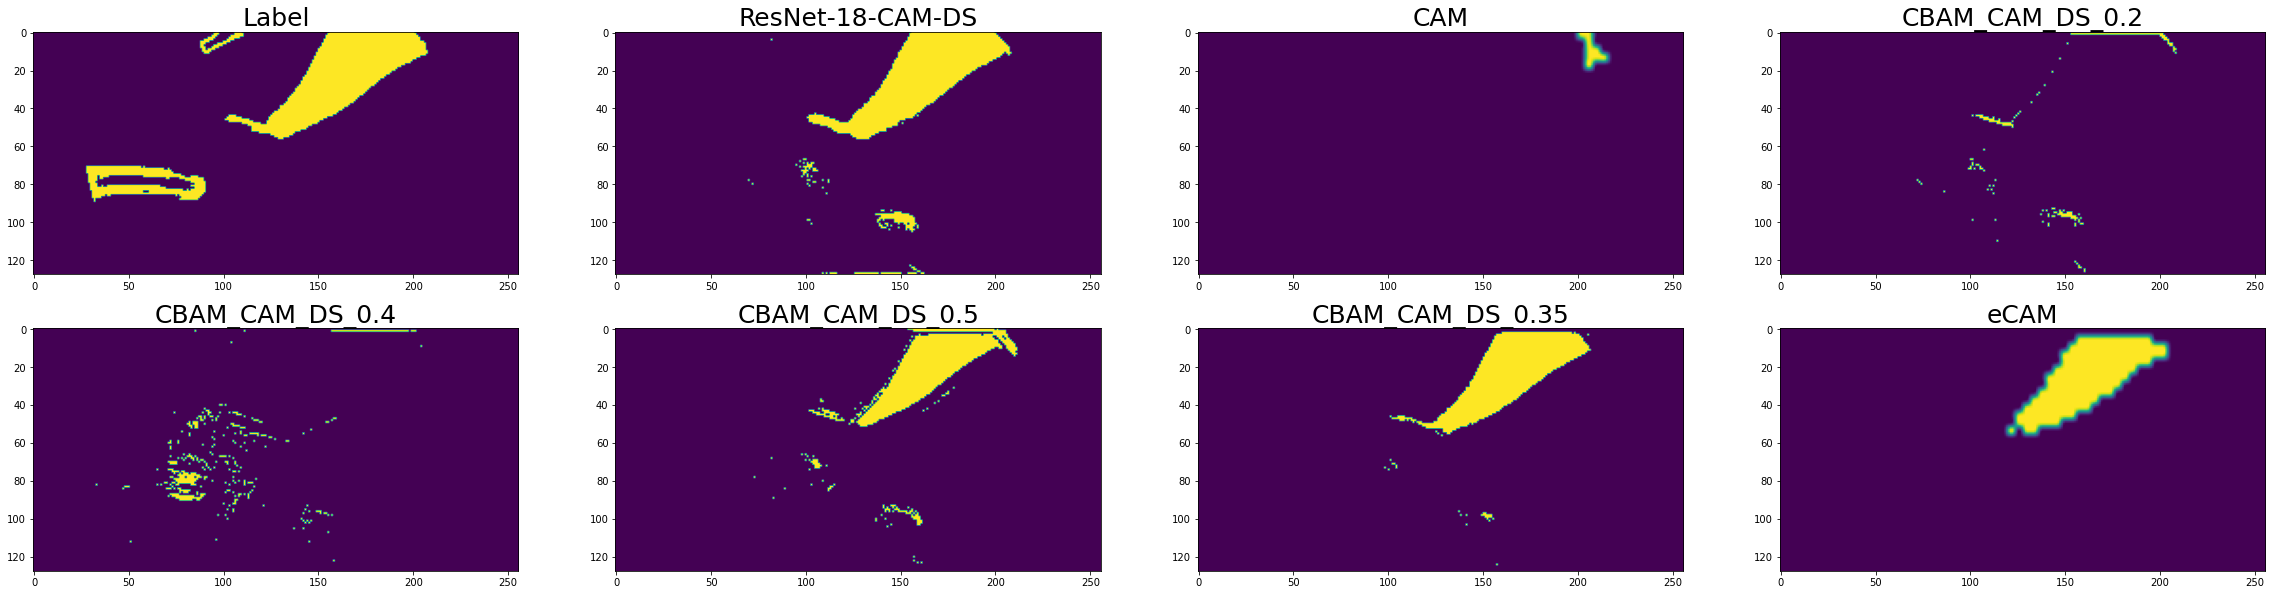

In [14]:
plt.figure()

plt.figure(figsize=(40,10))

img_name = 'frame_529_endo.png'
draw_seg(model, test_dir + img_name, 'acc_iou_f1/cbam0.35/{}'.format(img_name))
models_name = ['acc_iou_f1/label/', 'acc_iou_f1/cam/', 'acc_iou_f1/cam_1/', 'acc_iou_f1/cbam0.2/', 'acc_iou_f1/cbam0.4/', 'acc_iou_f1/cbam0.5/', 'acc_iou_f1/cbam0.35/', 'acc_iou_f1/ecam/']
titles = ['Label', 'ResNet-18-CAM-DS', 'CAM', 'CBAM_CAM_DS_0.2', 'CBAM_CAM_DS_0.4', 'CBAM_CAM_DS_0.5', 'CBAM_CAM_DS_0.35', 'eCAM']
for idx, model_name in enumerate(models_name):
  plt.subplot(2, 4, idx + 1)
  img = Image.open(model_name + img_name).resize((256,128))
  plt.imshow(img)
  plt.title('{}'.format(titles[idx]),fontsize=25)

plt.show()

<Figure size 432x288 with 0 Axes>

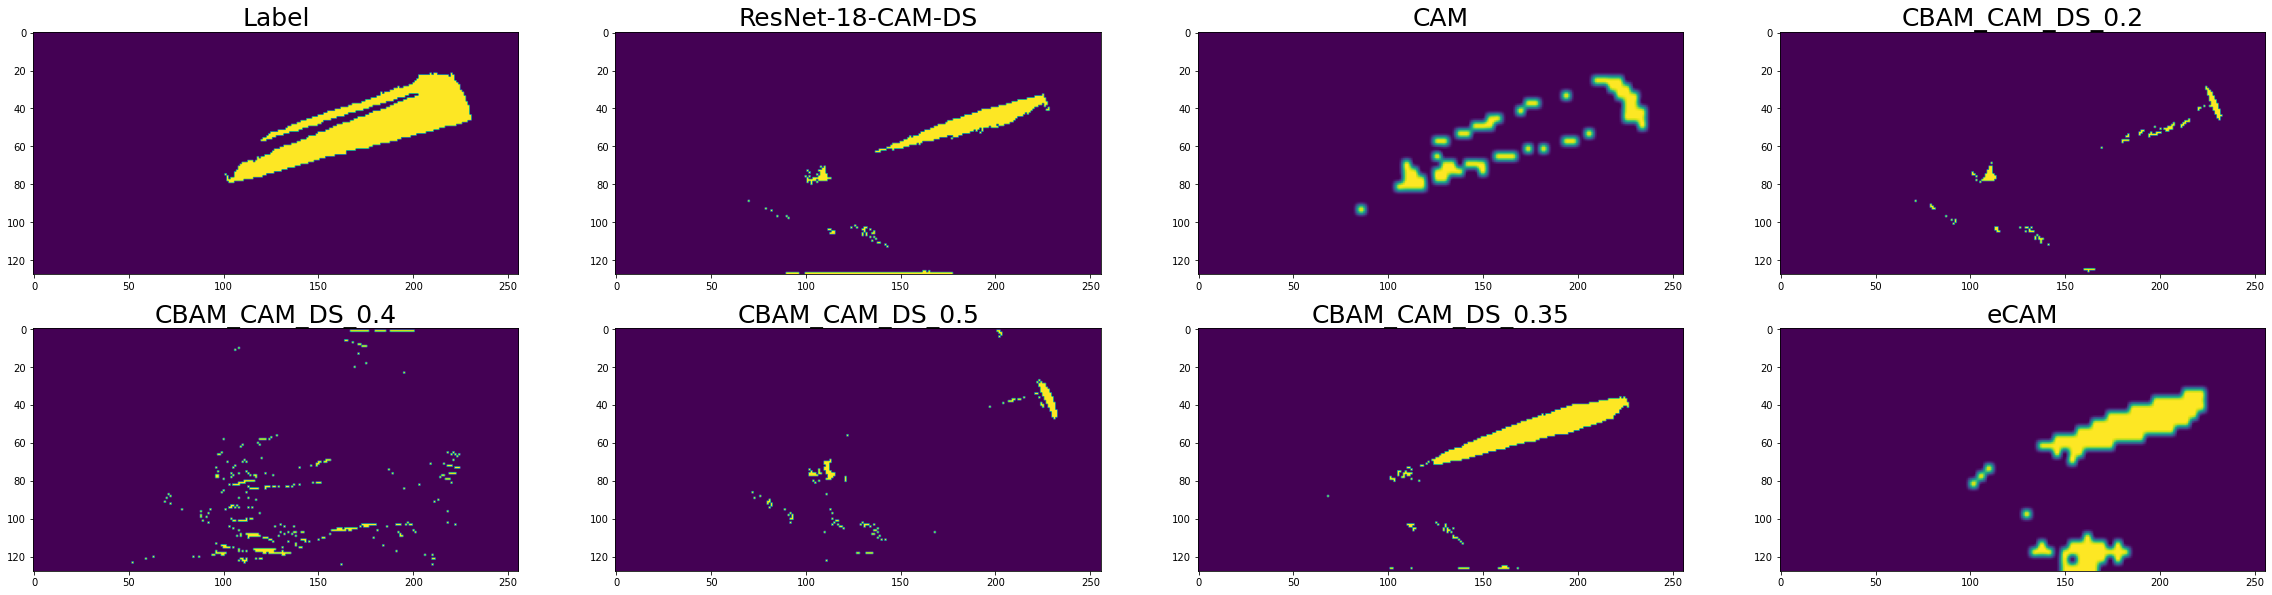

In [15]:
plt.figure()

plt.figure(figsize=(40,10))

img_name = 'frame_2756_endo.png'
draw_seg(model, test_dir + img_name, 'acc_iou_f1/cbam0.35/{}'.format(img_name))
models_name = ['acc_iou_f1/label/', 'acc_iou_f1/cam/', 'acc_iou_f1/cam_1/', 'acc_iou_f1/cbam0.2/', 'acc_iou_f1/cbam0.4/', 'acc_iou_f1/cbam0.5/', 'acc_iou_f1/cbam0.35/', 'acc_iou_f1/ecam/']
titles = ['Label', 'ResNet-18-CAM-DS', 'CAM', 'CBAM_CAM_DS_0.2', 'CBAM_CAM_DS_0.4', 'CBAM_CAM_DS_0.5', 'CBAM_CAM_DS_0.35', 'eCAM']
for idx, model_name in enumerate(models_name):
  plt.subplot(2, 4, idx + 1)
  img = Image.open(model_name + img_name).resize((256,128))
  plt.imshow(img)
  plt.title('{}'.format(titles[idx]),fontsize=25)

plt.show()

<Figure size 432x288 with 0 Axes>

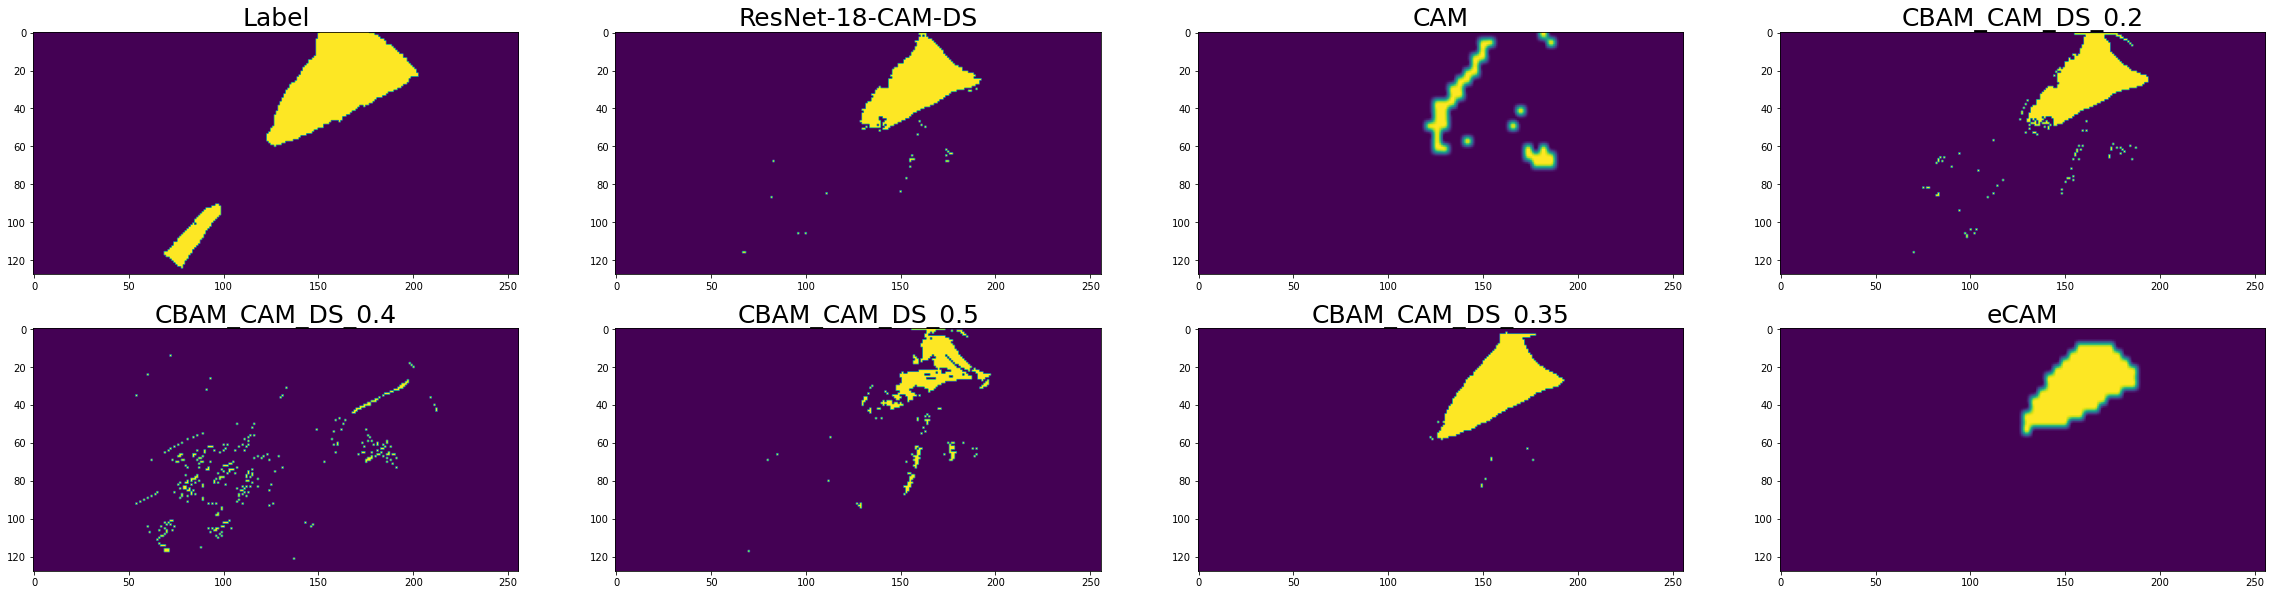

In [16]:
plt.figure()

plt.figure(figsize=(40,10))

img_name = 'frame_992_endo.png'
# draw_seg(model, test_dir + img_name, 'acc_iou_f1/cbam0.35/{}'.format(img_name))
models_name = ['acc_iou_f1/label/', 'acc_iou_f1/cam/', 'acc_iou_f1/cam_1/', 'acc_iou_f1/cbam0.2/', 'acc_iou_f1/cbam0.4/', 'acc_iou_f1/cbam0.5/', 'acc_iou_f1/cbam0.35/', 'acc_iou_f1/ecam/']
titles = ['Label', 'ResNet-18-CAM-DS', 'CAM', 'CBAM_CAM_DS_0.2', 'CBAM_CAM_DS_0.4', 'CBAM_CAM_DS_0.5', 'CBAM_CAM_DS_0.35', 'eCAM']
for idx, model_name in enumerate(models_name):
  plt.subplot(2, 4, idx + 1)
  img = Image.open(model_name + img_name).resize((256,128))
  plt.imshow(img)
  plt.title('{}'.format(titles[idx]),fontsize=25)

plt.show()
